In [299]:
import pandas as pd
import time
import sys
from pathlib import Path
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Go up one directory to get to master/
project_root = str(Path.cwd().parent)
sys.path.append(project_root)



In [300]:
def get_solutions_all_folds_rollOCT(name_dataset: str, depth=3, folds_available = 10) -> dict: #for 10 fold cross valdidation, carefull that trees have min depth 2
    sol_dict = {} # one entry for every fold, [fold][depth]['test'] for train_data classification for fold of depth; same for training
    for i in range(1,folds_available+1):
        sol_dict[i] = {}
        for j in range(2,depth+1):
            sol_dict[i][j] = {}
            sol_dict[i][j]['test'] = pd.read_csv(f"../results/{name_dataset}/pulp/fold{i}/depth{j}_classification_{name_dataset}_test.csv")
            sol_dict[i][j]['train'] = pd.read_csv(f"../results/{name_dataset}/pulp/fold{i}/depth{j}_classification_{name_dataset}_train.csv")
    return sol_dict

#sol_dict = get_solutions_all_folds_pulp(name_dataset=name_dataset, depth= max_depth_available)

#print(sol_dict[4][8]['train'])

In [301]:
def get_solutions_all_folds_cart(name_dataset: str, depth=3, folds_available = 10) -> dict: #for 10 fold cross valdidation, carefull that trees have min depth 2
    sol_dict = {} # one entry for every fold, [fold][depth]['test'] for train_data classification for fold of depth; same for training
    for i in range(1,folds_available+1):
        sol_dict[i] = {}
        for j in range(2,depth+1):
            sol_dict[i][j] = {}
            sol_dict[i][j]['test'] = pd.read_csv(f"../results/{name_dataset}/cart/fold{i}/depth{j}_classification_{name_dataset}_test.csv")
            sol_dict[i][j]['train'] = pd.read_csv(f"../results/{name_dataset}/cart/fold{i}/depth{j}_classification_{name_dataset}_train.csv")
    return sol_dict

damit das hier immer funktioniert, muss das mapping vom binarizer auf die Zahlen immer gleich sein

Achtung: Man muss noch in den Ergebnissen zuordnen was in den Ursprungsdatensatz (das binarized wurde) als positive und was als negative gesehen wird. Also wie das label jetzt heißt dem ursprünglichen label zuordnen

=> Ich habe mich entschieden das schon beim binarizen zu machen

In [302]:
def acc_sens_spec_prec_bin(solution, pos_represent, neg_represent):
    tp = len(solution[(solution['y'] == pos_represent) & (solution['prediction'] == pos_represent)])
    tn = len(solution[(solution['y'] == neg_represent) & (solution['prediction'] == neg_represent)])
    fp = len(solution[(solution['y'] == neg_represent) & (solution['prediction'] == pos_represent)])
    fn = len(solution[(solution['y'] == pos_represent) & (solution['prediction'] == neg_represent)])
    number_datapoints = tp+tn+fp+fn
    if number_datapoints != len(solution):
        print('error in calculation of acc')
    sensitivity = tp/(tp+fn) #also called recall, True Positive Rate
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    accuracy = (tp+tn)/number_datapoints
    return accuracy, sensitivity, specificity,precision


In [303]:
# does not contain time stuff
def solutions_all_depths_all_folds_bin(dataset_name, pos_represent, neg_represent, max_tree_depth, folds_available):
    sol_dict = get_solutions_all_folds_pulp(name_dataset = dataset_name, depth=max_tree_depth, folds_available = folds_available)
    result_dict = dict()
    for depth in range(2,max_tree_depth+1):
        result_dict[depth] = dict()
        result_dict[depth]['test'] = dict()
        result_dict[depth]['train'] = dict()
        sensitivity_test, specificity_test, precision_test, accuracy_test = 0, 0, 0, 0
        sensitivity_train, specificity_train, precision_train, accuracy_train = 0, 0, 0, 0
        for fold in range(1, folds_available+1):
            sol_test = sol_dict[fold][depth]['test']
            sol_train = sol_dict[fold][depth]['train']
            acc_fold_test, sens_fold_test, spec_fold_test, prec_fold_test = acc_sens_spec_prec_bin(sol_test, pos_represent, neg_represent)
            acc_fold_train, sens_fold_train, spec_fold_train, prec_fold_train = acc_sens_spec_prec_bin(sol_train, pos_represent, neg_represent)

            sensitivity_test += sens_fold_test
            specificity_test += spec_fold_test
            precision_test += prec_fold_test
            accuracy_test += acc_fold_test

            sensitivity_train += sens_fold_train
            specificity_train += spec_fold_train
            precision_train += prec_fold_train
            accuracy_train += acc_fold_train
        
        result_dict[depth]['test']['sensitivity'] = sensitivity_test/folds_available
        result_dict[depth]['test']['specificity'] = specificity_test/folds_available
        result_dict[depth]['test']['precision'] = precision_test/folds_available
        result_dict[depth]['test']['accuracy'] = accuracy_test/folds_available

        result_dict[depth]['train']['sensitivity'] = sensitivity_train/folds_available
        result_dict[depth]['train']['specificity'] = specificity_train/folds_available
        result_dict[depth]['train']['precision'] = precision_train/folds_available
        result_dict[depth]['train']['accuracy'] = accuracy_train/folds_available
    return result_dict





In [304]:
def get_class_confusion_values(cm, class_idx):
    tp = cm[class_idx, class_idx]
    fn = cm[class_idx, :].sum() - tp
    fp = cm[:, class_idx].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    return tp, fp, fn, tn

In [305]:
def calc_acc_sens_spec_prec(tp, fp, fn, tn):
    #number_datapoints = tp+tn+fp+fn
    sensitivity = tp/(tp+fn) #also called recall, True Positive Rate
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    #accuracy = (tp+tn)/number_datapoints
    #return accuracy, sensitivity, specificity,precision
    return sensitivity, specificity,precision

In [306]:
def calc_f1(result_dict, list_target_vars, max_tree_depth):
    for depth in range(2,max_tree_depth+1):
        for i,class_idx in enumerate(list_target_vars):
            precision_test = result_dict[depth]['test'][class_idx]['precision']
            precision_train = result_dict[depth]['train'][class_idx]['precision']

            sensitivity_test = result_dict[depth]['test'][class_idx]['sensitivity'] #also called recall
            sensitivity_train = result_dict[depth]['train'][class_idx]['sensitivity']
            
            result_dict[depth]['test'][class_idx]['f1'] = 2*((precision_test*sensitivity_test)/(precision_test+sensitivity_test))
            result_dict[depth]['train'][class_idx]['f1'] = 2*((precision_train*sensitivity_train)/(precision_train+sensitivity_train))
    return result_dict

Achtung bei class_idx-1 bei Aufruf get_class_confusion_values(cm_test, class_idx-1). Dies ist so, weil confusion matrix cm 0 initialisiertes Array ist.

Wenn bei mir alle class_idx durch preporecessing mit 1 initialisiert sind, dann schifte ich die alle einfach um -1.

In [307]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, matthews_corrcoef

# does not contain time stuff
# man muss über die target vars iterieren
# we want result_dict[depth]['test'/'train'][target_var] and then sens,spec,prec,acc dor all folds. Then we are able to combine it with original target var afterwards
def solutions_all_depths_all_folds_multiclass(dataset_name, list_target_vars, max_tree_depth, folds_available, cart = False):
    if cart == False:
        sol_dict = get_solutions_all_folds_rollOCT(name_dataset = dataset_name, depth=max_tree_depth, folds_available = folds_available)
    else:
        sol_dict = get_solutions_all_folds_cart(name_dataset = dataset_name, depth=max_tree_depth, folds_available = folds_available)
    result_dict = dict()
    for depth in range(2,max_tree_depth+1):
        result_dict[depth] = dict()
        result_dict[depth]['test'] = dict()
        result_dict[depth]['train'] = dict()

        result_dict[depth]['test']['accuracy'] = 0
        result_dict[depth]['train']['accuracy'] = 0

        mcc_scores_test = []
        mcc_scores_train = []

        for i,class_idx in enumerate(list_target_vars): #initialize per depth
                result_dict[depth]['test'][class_idx] = dict()
                result_dict[depth]['train'][class_idx] = dict()

                #result_dict[depth]['test'][class_idx]['accuracy'] = 0
                result_dict[depth]['test'][class_idx]['sensitivity'] = 0
                result_dict[depth]['test'][class_idx]['specificity'] = 0
                result_dict[depth]['test'][class_idx]['precision'] = 0
                result_dict[depth]['test'][class_idx]['f1'] = 0

                #result_dict[depth]['train'][class_idx]['accuracy'] = 0
                result_dict[depth]['train'][class_idx]['sensitivity'] = 0
                result_dict[depth]['train'][class_idx]['specificity'] = 0
                result_dict[depth]['train'][class_idx]['precision'] = 0
                result_dict[depth]['train'][class_idx]['f1'] = 0

        for fold in range(1, folds_available+1):
            
            y_true_test = sol_dict[fold][depth]['test']['y']
            y_predict_test = sol_dict[fold][depth]['test']['prediction']

            y_true_train = sol_dict[fold][depth]['train']['y']
            y_predict_train = sol_dict[fold][depth]['train']['prediction']

            cm_test = confusion_matrix(y_true_test, y_predict_test) #(true labels, predicted labels)
            cm_train = confusion_matrix(y_true_train, y_predict_train)

            result_dict[depth]['test']['accuracy'] += accuracy_score(y_true_test, y_predict_test) / folds_available
            result_dict[depth]['train']['accuracy'] += accuracy_score(y_true_train, y_predict_train) / folds_available
            
            mcc_test = matthews_corrcoef(y_true_test, y_predict_test) #For a multiclass problem, sklearn.metrics.matthews_corrcoef returns a single float value representing the overall Matthews correlation coefficient (MCC) across all classes
            mcc_train = matthews_corrcoef(y_true_train, y_predict_train)

            mcc_scores_test.append(mcc_test)
            mcc_scores_train.append(mcc_train)

            
            #cm_test = confusion_matrix(sol_dict[fold][depth]['test']['y'], sol_dict[fold][depth]['test']['prediction']) #(true labels, predicted labels)
            #cm_train = confusion_matrix(sol_dict[fold][depth]['train']['y'], sol_dict[fold][depth]['train']['prediction'])

            #result_dict[depth]['test']['accuracy'] += accuracy_score(sol_dict[fold][depth]['test']['y'], sol_dict[fold][depth]['test']['prediction']) / folds_available
            #result_dict[depth]['train']['accuracy'] += accuracy_score(sol_dict[fold][depth]['train']['y'], sol_dict[fold][depth]['train']['prediction']) / folds_available
            
            for j,class_idx in enumerate(list_target_vars): #every target class possible


                tp_test, fp_test, fn_test, tn_test = get_class_confusion_values(cm_test, class_idx-1) #-1 because conusion matrix cm starts indices with 0
                tp_train, fp_train, fn_train, tn_train = get_class_confusion_values(cm_train, class_idx-1)

                sens_test, spec_test, prec_test = calc_acc_sens_spec_prec(tp_test, fp_test, fn_test, tn_test)
                sens_train, spec_train, prec_train = calc_acc_sens_spec_prec(tp_train, fp_train, fn_train, tn_train)

                #acc_test, sens_test, spec_test, prec_test = calc_acc_sens_spec_prec(tp_test, fp_test, fn_test, tn_test)
                #acc_train, sens_train, spec_train, prec_train = calc_acc_sens_spec_prec(tp_train, fp_train, fn_train, tn_train)

                #result_dict[depth]['test'][class_idx]['accuracy'] += acc_test/folds_available #division here could maybe lead to precision problems
                result_dict[depth]['test'][class_idx]['sensitivity'] += sens_test/folds_available
                result_dict[depth]['test'][class_idx]['specificity'] += spec_test/folds_available
                result_dict[depth]['test'][class_idx]['precision'] += prec_test/folds_available

                #result_dict[depth]['train'][class_idx]['accuracy'] += acc_train/folds_available
                result_dict[depth]['train'][class_idx]['sensitivity'] += sens_train/folds_available
                result_dict[depth]['train'][class_idx]['specificity'] += spec_train/folds_available
                result_dict[depth]['train'][class_idx]['precision'] += prec_train/folds_available
        
        mean_mcc_test = np.mean(mcc_scores_test)
        mean_mcc_train = np.mean(mcc_scores_train)

        result_dict[depth]['test']['mcc'] = mean_mcc_test
        result_dict[depth]['train']['mcc'] = mean_mcc_train

        #std_mcc_test = np.std(mcc_scores_test)
        #std_mcc_train = np.std(mcc_scores_train)
    
    result_dict = calc_f1(result_dict= result_dict, list_target_vars= list_target_vars, max_tree_depth=max_tree_depth)
    
    return result_dict

In [308]:
def get_evaluation_for_class(result_dict, target_var, depth, training_data = False):
    rows_depths = []
    cols = ['sensitivity','specificity', 'precision', 'f1']
    for i in range(2,depth+1):
        rows_depths.append(f'depth{i}')
    df = pd.DataFrame([], index=rows_depths, columns=cols)
    for j in range(2,depth+1):
        if training_data == False:
            df.at[f'depth{j}', 'sensitivity'] = result_dict[j]['test'][target_var]['sensitivity']
            df.at[f'depth{j}', 'specificity'] = result_dict[j]['test'][target_var]['specificity']
            df.at[f'depth{j}', 'precision'] = result_dict[j]['test'][target_var]['precision']
            df.at[f'depth{j}', 'f1'] = result_dict[j]['test'][target_var]['f1']
        else:
            df.at[f'depth{j}', 'sensitivity'] = result_dict[j]['train'][target_var]['sensitivity']
            df.at[f'depth{j}', 'specificity'] = result_dict[j]['train'][target_var]['specificity']
            df.at[f'depth{j}', 'precision'] = result_dict[j]['train'][target_var]['precision']
            df.at[f'depth{j}', 'f1'] = result_dict[j]['train'][target_var]['f1']

    return df

In [309]:
def get_accuracy_every_depth(result_dict, depth):
    rows_depths = []
    cols = ['test','train']
    for i in range(2,depth+1):
        rows_depths.append(f'depth{i}')
    df = pd.DataFrame([], index=rows_depths, columns=cols)
    for j in range(2,depth+1):
        df.at[f'depth{j}', 'test'] = result_dict[j]['test']['accuracy']
        df.at[f'depth{j}', 'train'] = result_dict[j]['train']['accuracy']
    return df



In [310]:
def get_mcc_every_depth(result_dict, depth): #Matthews Correlation Coefficient
    rows_depths = []
    cols = ['test','train']
    for i in range(2,depth+1):
        rows_depths.append(f'depth{i}')
    df = pd.DataFrame([], index=rows_depths, columns=cols)
    for j in range(2,depth+1):
        df.at[f'depth{j}', 'test'] = result_dict[j]['test']['mcc']
        df.at[f'depth{j}', 'train'] = result_dict[j]['train']['mcc']
    return df

In [311]:
# also comparison between rollOCT and CART
def visualize_acc_mcc(result_dict_rollOCT, result_dict_cart, name_dataset, max_depth, train = False): #metrics single value over all vars
    if train == False:
        var = 'test'
        name = 'out-of-sample'
    else:
        var = 'train'
        name = 'in-sample'
    categories = []
    for i in range(2,max_depth+1):
        categories.append(i)

    acc_rollOCT = get_accuracy_every_depth(result_dict = result_dict_rollOCT, depth=max_depth)
    acc_cart = get_accuracy_every_depth(result_dict = result_dict_cart, depth=max_depth)

    acc_rollOCT = acc_rollOCT[var]
    acc_cart = acc_cart[var]

    mcc_rollOCT = get_mcc_every_depth(result_dict = result_dict_rollOCT, depth=max_depth)
    mcc_cart = get_mcc_every_depth(result_dict = result_dict_cart, depth=max_depth)

    mcc_rollOCT = mcc_rollOCT[var]
    mcc_cart = mcc_cart[var]

    bar_width = 0.25

    # Positions of the bars on x-axis for the groups
    x = np.arange(len(categories))

    fig, axes = plt.subplots(1, 2, figsize=(10, 8))
    ax = axes.ravel()

    ax[0].bar(x - bar_width, acc_rollOCT, width=bar_width, label='rollOCT')
    ax[0].bar(x, acc_cart, width=bar_width, label='CART')
    ax[0].set_xticks(ticks=x, labels=categories)
    ax[0].set_xlabel('Depth')
    ax[0].set_ylabel('accuracy')
    ax[0].set_title(f'{name} accuracy; dataset {name_dataset}')
    ax[0].legend(loc='lower left')

    ax[1].bar(x - bar_width, mcc_rollOCT, width=bar_width, label='rollOCT')
    ax[1].bar(x, mcc_cart, width=bar_width, label='CART')
    ax[1].set_xticks(ticks=x, labels=categories)
    ax[1].set_xlabel('Depth')
    ax[1].set_ylabel('mcc')
    ax[1].set_title(f'{name} Matthews Correlation Coefficient; dataset {name_dataset}')
    ax[1].legend(loc='lower left')



    # Plot bars for each dataset with appropriate offset
    #plt.bar(x - bar_width, acc_rollOCT, width=bar_width, label='rollOCT')
    #plt.bar(x, acc_cart, width=bar_width, label='CART')


    # Set x-ticks and labels
    #plt.xticks(ticks=x, labels=categories)


    # Label axes and title
    #plt.xlabel('Depth')
    #plt.ylabel('Accuracy')
    #plt.title(f'{name} accuracy; dataset {name_dataset}')
    
    # Show legend
    #plt.legend()

    fig.tight_layout()
    # Show plot
    plt.show()

    return None

In [312]:
def plot_var_on_ax(ax, x, categories, bar_width, dataset_var_rollOCT, dataset_var_cart, dataset_name, metric_name, metric_short, train=False):
    ax.bar(x - bar_width, dataset_var_rollOCT, width=bar_width, label='rollOCT')
    ax.bar(x, dataset_var_cart, width=bar_width, label='CART')
    ax.set_xticks(ticks=x, labels=categories)
    ax.set_xlabel('depth')
    ax.set_ylabel(metric_short)
    if train == False:
        ax.set_title(f'out-of-sample {metric_name}; dataset {dataset_name}')
    else:
        ax.set_title(f'in-sample {metric_name}; dataset {dataset_name}')
    ax.legend(loc='lower left')
    

# Auswertung für jeden Datensatz

Was positive/negative target var ist und wovon sie repräsentiert wird, kann man in der jeweiligen Datei nachschauen

In [313]:
# <=50K:1; >50K:2
#result_dict_adult = solutions_all_depths_all_folds_bin(dataset_name='adult', pos_represent=1, neg_represent=2, max_tree_depth=8, folds_available=10)

#print(result_dict_adult[8]['test']['accuracy'])

meaning_target_vars = {
    1 : '<=50K',
    2 : '>50K'
}

target_vars = [1,2]

result_dict_adult_rollOCT = solutions_all_depths_all_folds_multiclass(dataset_name='adult', list_target_vars = target_vars, max_tree_depth=8, folds_available=10, cart=False)
result_dict_adult_cart = solutions_all_depths_all_folds_multiclass(dataset_name='adult', list_target_vars = target_vars, max_tree_depth=8, folds_available=10, cart=True)

accuracy_adult = get_accuracy_every_depth(result_dict_adult_rollOCT, depth=8)

print(accuracy_adult)




            test     train
depth2  0.807502  0.807502
depth3  0.818148  0.818417
depth4  0.820503  0.821743
depth5  0.823492  0.824871
depth6  0.824188  0.828838
depth7  0.827628  0.835215
depth8  0.829491  0.839414


In [314]:
mcc_adult = get_mcc_every_depth(result_dict_adult_rollOCT, depth=8)

print(mcc_adult)

            test     train
depth2  0.484863  0.484846
depth3  0.457045  0.457949
depth4  0.445829  0.450375
depth5   0.45841  0.463336
depth6   0.50255  0.514052
depth7  0.501515  0.522662
depth8  0.487553  0.519078


In [315]:
for i,name in enumerate(target_vars):
    print(f'Var {meaning_target_vars[name]} results for test data:\n')
    print(get_evaluation_for_class(result_dict_adult_rollOCT, target_var=name, depth=8, training_data = False))
    print(f'Var {meaning_target_vars[name]} results for  training data:\n')
    print(get_evaluation_for_class(result_dict_adult_rollOCT, target_var=name, depth=8, training_data = True))
    print('\n')

Var <=50K results for test data:

       sensitivity specificity precision        f1
depth2    0.861849    0.634721  0.882402  0.872004
depth3    0.924425    0.480276  0.849758   0.88552
depth4    0.951716    0.403352  0.835313  0.889723
depth5    0.949428    0.423117  0.839575  0.891129
depth6    0.901197    0.579357  0.872619  0.886678
depth7     0.91487    0.550263   0.86666  0.890113
depth8    0.938474    0.483015  0.852348   0.89334
Var <=50K results for  training data:

       sensitivity specificity precision        f1
depth2    0.861849    0.634722  0.882368  0.871988
depth3    0.924595    0.480857  0.849905  0.885678
depth4    0.952182    0.407053  0.836241  0.890453
depth5    0.950044    0.426923  0.840538  0.891942
depth6      0.9056      0.5848  0.874637  0.889849
depth7    0.921013    0.562449  0.870585  0.895089
depth8    0.945125    0.503342  0.858157  0.899544


Var >50K results for test data:

       sensitivity specificity precision        f1
depth2    0.634721    0.8

In [316]:
print(get_accuracy_every_depth(result_dict_adult_rollOCT, depth=8).at['depth8', 'test'])

0.8294909997929445


In [317]:
print(result_dict_adult_rollOCT[3]['test']['mcc']) #For a multiclass problem, sklearn.metrics.matthews_corrcoef returns a single float value representing the overall Matthews correlation coefficient (MCC) across all classes

0.4570450261194325


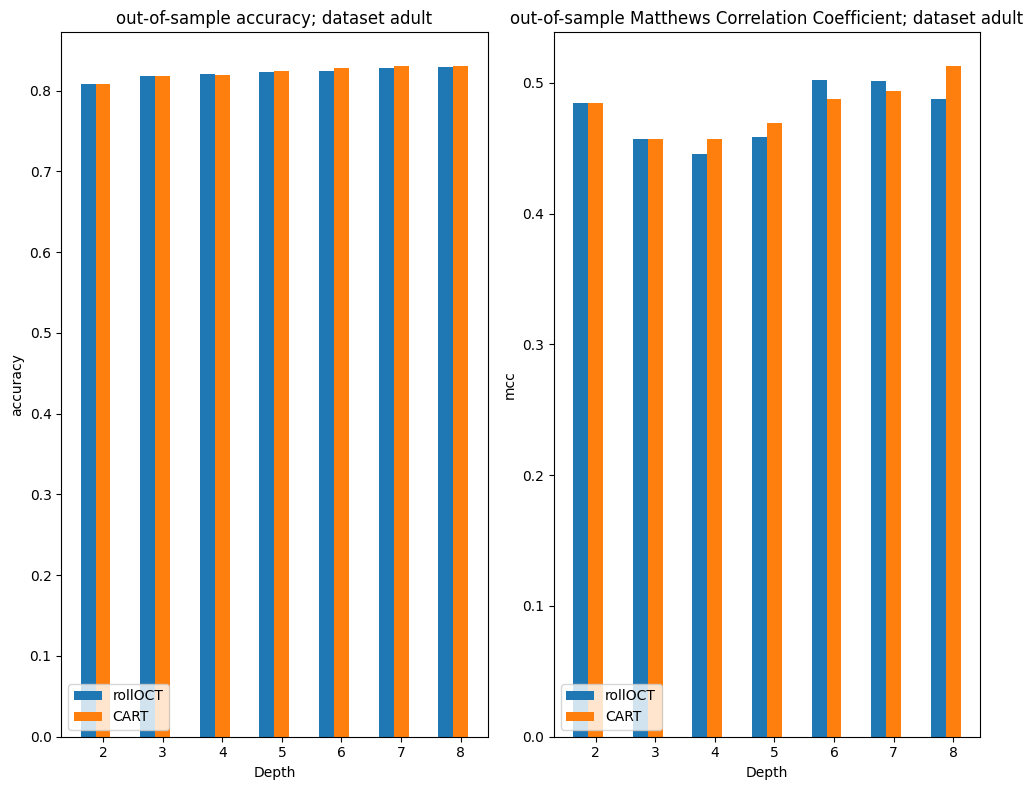

In [318]:
visualize_acc_mcc(result_dict_rollOCT = result_dict_adult_rollOCT, result_dict_cart = result_dict_adult_cart, name_dataset = 'adult', max_depth = 8, train = False)

Beispiel Auswertung für ein Dataset, am Beispiel adult

dies später dann abstrahieren

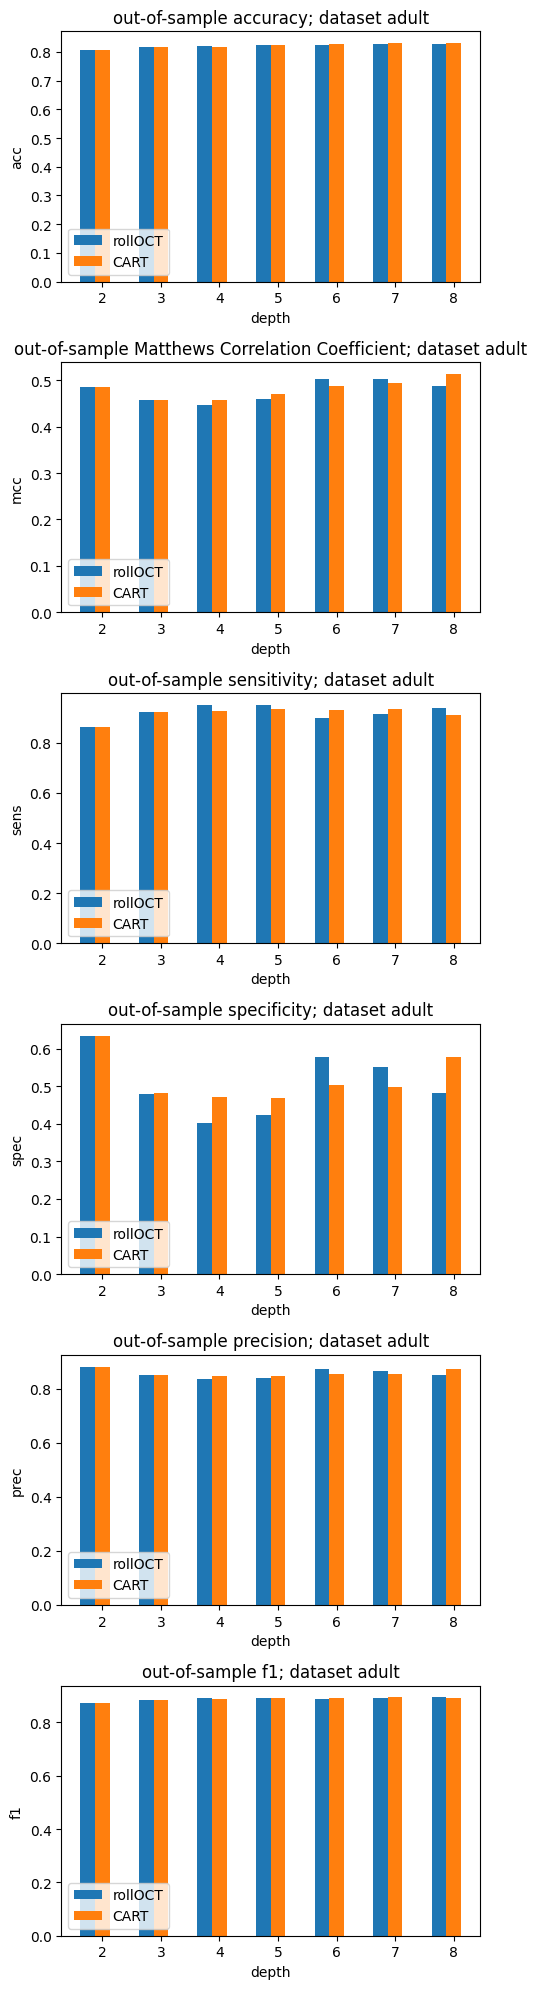

In [327]:
#muss nachgeschaut werden:
meaning_target_vars = {
    1 : '<=50K',
    2 : '>50K'
}

target_vars = [1,2]

depth_tree = 8

metrics = 6

#ergebnisse holen:
result_dict_adult_rollOCT = solutions_all_depths_all_folds_multiclass(dataset_name='adult', list_target_vars = target_vars, max_tree_depth=depth_tree, folds_available=10, cart=False)
result_dict_adult_cart = solutions_all_depths_all_folds_multiclass(dataset_name='adult', list_target_vars = target_vars, max_tree_depth=depth_tree, folds_available=10, cart=True)

accuracy_adult_rollOCT = get_accuracy_every_depth(result_dict_adult_rollOCT, depth=depth_tree) #get acc for every depth; out of sample and in sample
mcc_adult_rollOCT = get_mcc_every_depth(result_dict_adult_rollOCT, depth=depth_tree) #get mcc for every depth; out of sample and in sample

accuracy_adult_cart = get_accuracy_every_depth(result_dict_adult_cart, depth=depth_tree) #get acc
mcc_adult_cart = get_mcc_every_depth(result_dict_adult_cart, depth=depth_tree) #get mcc

desired_target_var = 1
get_in_sample_results = False

if get_in_sample_results == False: 
    accuracy_adult_rollOCT = accuracy_adult_rollOCT['test']
    mcc_adult_rollOCT = mcc_adult_rollOCT['test']
    accuracy_adult_cart = accuracy_adult_cart['test']
    mcc_adult_cart = mcc_adult_cart['test']
else:
    accuracy_adult_rollOCT = accuracy_adult_rollOCT['train']
    mcc_adult_rollOCT = mcc_adult_rollOCT['train']
    accuracy_adult_cart = accuracy_adult_cart['train']
    mcc_adult_cart = mcc_adult_cart['train']

eval_rollOCT = get_evaluation_for_class(result_dict_adult_rollOCT, target_var=desired_target_var, depth=depth_tree, training_data = get_in_sample_results) #get sensitivity, specificity, precision, f1 for chosen target var over all depths
eval_cart = get_evaluation_for_class(result_dict_adult_cart, target_var=desired_target_var, depth=depth_tree, training_data = get_in_sample_results)

bar_width = 0.25

categories = []
for i in range(2,depth_tree+1):
    categories.append(i)

# Positions of the bars on x-axis for the groups
x = np.arange(len(categories))

fig, axes = plt.subplots(metrics, 1, figsize=(5, 20))
ax = axes.ravel()

plot_var_on_ax(ax[0], x, categories, bar_width, dataset_var_rollOCT = accuracy_adult_rollOCT, dataset_var_cart = accuracy_adult_cart, dataset_name = 'adult', metric_name = 'accuracy', metric_short = 'acc', train=get_in_sample_results) #accuracy
plot_var_on_ax(ax[1], x, categories, bar_width, dataset_var_rollOCT = mcc_adult_rollOCT, dataset_var_cart = mcc_adult_cart, dataset_name = 'adult', metric_name = 'Matthews Correlation Coefficient',metric_short = 'mcc', train=get_in_sample_results) #mcc
plot_var_on_ax(ax[2], x, categories, bar_width, dataset_var_rollOCT = eval_rollOCT['sensitivity'], dataset_var_cart = eval_cart['sensitivity'], dataset_name = 'adult', metric_name = 'sensitivity',metric_short = 'sens', train=get_in_sample_results) #sensitivity
plot_var_on_ax(ax[3], x, categories, bar_width, dataset_var_rollOCT = eval_rollOCT['specificity'], dataset_var_cart = eval_cart['specificity'], dataset_name = 'adult',metric_name = 'specificity',metric_short = 'spec', train=get_in_sample_results) #specificity
plot_var_on_ax(ax[4], x, categories, bar_width, dataset_var_rollOCT = eval_rollOCT['precision'], dataset_var_cart = eval_cart['precision'], dataset_name = 'adult',metric_name = 'precision',metric_short = 'prec', train=get_in_sample_results) #precision
plot_var_on_ax(ax[5], x, categories, bar_width, dataset_var_rollOCT = eval_rollOCT['f1'], dataset_var_cart = eval_cart['f1'], dataset_name = 'adult',metric_name = 'f1',metric_short = 'f1', train=get_in_sample_results) #f1

fig.tight_layout()
# Show plot
plt.show()




# Ausprobieren

In [320]:
sol_dict_adult_rollOCT = get_solutions_all_folds_rollOCT(name_dataset='adult', depth=8, folds_available = 10)
sol_dict_adult_cart = get_solutions_all_folds_cart(name_dataset='adult', depth=8, folds_available = 10)

print(sol_dict_adult_rollOCT[1][8]['test']) #fold, depth, datatype



      Unnamed: 0  y  prediction  leaf
0              0  1           1   479
1             24  1           1   511
2             32  1           1   479
3             76  1           1   383
4             78  1           1   503
...          ... ..         ...   ...
4880       48831  1           1   303
4881       48832  1           1   303
4882       48833  1           1   300
4883       48839  1           2   351
4884       48841  2           2   349

[4885 rows x 4 columns]


In [321]:
 #y_true and y_pred are your true and predicted class labels, respectively
# report = classification_report(y_true, y_pred)

report_adult = classification_report(sol_dict_adult_rollOCT[1][8]['test']['y'], sol_dict_adult_rollOCT[1][8]['test']['prediction'])
print(report_adult)

              precision    recall  f1-score   support

           1       0.85      0.94      0.89      3716
           2       0.70      0.46      0.56      1169

    accuracy                           0.82      4885
   macro avg       0.77      0.70      0.72      4885
weighted avg       0.81      0.82      0.81      4885



In [322]:
accuracy = accuracy_score(sol_dict_adult_rollOCT[1][8]['test']['y'], sol_dict_adult_rollOCT[1][8]['test']['prediction'])
print(accuracy)

0.824360286591607


In [323]:
#y_true = [...]  # true labels
#y_pred = [...]  # predicted labels

# Compute confusion matrix
#cm = confusion_matrix(y_true, y_pred)

sol_dict_nursery = get_solutions_all_folds_rollOCT(name_dataset='nursery', depth=8, folds_available = 10)

# Compute confusion matrix
cm = confusion_matrix(sol_dict_nursery[1][8]['test']['y'], sol_dict_nursery[1][8]['test']['prediction'])

#tn, fp, fn, tp = cm.ravel() #just for binary?
# For binary classification, cm looks like:
# [[TN, FP],
#  [FN, TP]]

print(cm)
print(cm[0])
print(cm.ravel())


[[432   0   0   0   0]
 [  0 397   0  20   9]
 [  0   0   0   0   1]
 [  0  26   0 378   0]
 [  0  15   0   0  18]]
[432   0   0   0   0]
[432   0   0   0   0   0 397   0  20   9   0   0   0   0   1   0  26   0
 378   0   0  15   0   0  18]


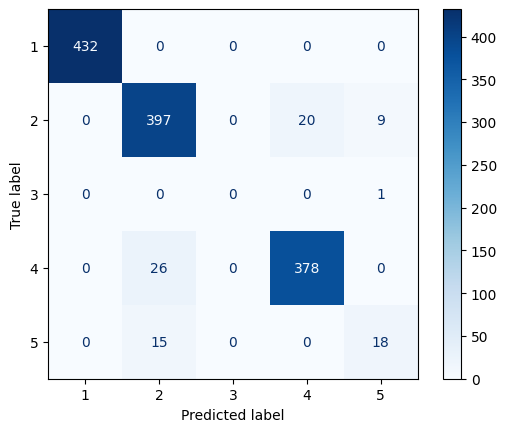

In [324]:
# Optional: specify class labels for better readability
class_names = [1, 2, 3, 4, 5]

# Create and plot confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")  # You can change colormap here
plt.show()

In [325]:
"""
def get_class_confusion_values(cm, class_idx):
    TP = cm[class_idx, class_idx]
    FN = cm[class_idx, :].sum() - TP
    FP = cm[:, class_idx].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    return TP, FP, FN, TN

# Example usage with confusion matrix cm and number of classes n_classes
for i in range(cm.shape[0]):
    TP, FP, FN, TN = get_class_confusion_values(cm, i)
    print(f"Class {i}: TP={TP}, FP={FP}, FN={FN}, TN={TN}")

"""

'\ndef get_class_confusion_values(cm, class_idx):\n    TP = cm[class_idx, class_idx]\n    FN = cm[class_idx, :].sum() - TP\n    FP = cm[:, class_idx].sum() - TP\n    TN = cm.sum() - (TP + FP + FN)\n    return TP, FP, FN, TN\n\n# Example usage with confusion matrix cm and number of classes n_classes\nfor i in range(cm.shape[0]):\n    TP, FP, FN, TN = get_class_confusion_values(cm, i)\n    print(f"Class {i}: TP={TP}, FP={FP}, FN={FN}, TN={TN}")\n\n'